# Read in raw politifact stories, filter for relevant stories

Filter links:
 - twitter or blog
 - between 2021-06-01 and 2023-12-20 
 - truth value in ['pants-fire', 'false', 'mostly-false']
 - health cat in CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']

In [6]:
import ast
import pandas as pd 
import numpy as np 
from datetime import datetime 

START_DATE = '2021-06-01'
END_DATE = '2023-12-21'

CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']
TRUTH_VALUES = ['pants-fire', 'false', 'mostly-false']


def is_twitter(desc):
    try:
        desc = desc.lower()
        if "twitter" in desc or "tweet" in desc or "post on x" in desc or "x-post" in desc or "x post" in desc or "en x" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    

def is_blog(desc):
    try:
        desc = desc.lower()
        if "in a blog" in desc or "bloggers" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    
def is_valid_category(x, categories):
    x = [i.lower() for i in x]
    if len(set(x).intersection(set(categories))) > 0:
        return True
    else:
        return False
    
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except:
        return s  
    
input_fn = "raw_pf_links_2023-12-22__10_31_08.csv"
output_fn = "filtered_tweets.csv"


df = pd.read_csv(input_fn)

# Filtered df
df['tags'] = df['tags'].apply(lambda x: safe_literal_eval(x))
df['is_twitter'] = df['raw_desc'].apply(lambda x: is_twitter(x))
df['is_blog_desc'] = df['raw_desc'].apply(lambda x: is_blog(x))
df['is_blog_cat'] = df['type'].apply(lambda x: 1 if x=="Bloggers" else 0)
df['is_blog'] = np.maximum(df['is_blog_desc'], df['is_blog_cat'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
filtered_df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
filtered_df = filtered_df[filtered_df['tags'].apply(lambda x: is_valid_category(x, CATEGORIES))]
filtered_df = filtered_df.query("truth_value in @TRUTH_VALUES")
filtered_df = filtered_df.query("is_twitter==1|is_blog==1")
filtered_df.to_csv(f"raw_{output_fn}")

# One df for manual validation 
filtered_df['annotated_column'] = ''
filtered_df['raw_url'] = ''
filtered_df['twitter_handle'] = ''
filtered_df['n_followers'] = ''
filtered_df.to_csv(f"to_annotate_{output_fn}")

# Now manually annotate and rename "annotated_{output_fn}" so don't write over

# Read in annotated df

In [62]:
adf = pd.read_csv("annotated_filtered_tweets_v2.csv")
adf = adf.query("problem==0")
adf = adf.query("'elected_rep' not in annotated_column")

adf = adf[adf['twitter_handle'].notna()]

print("Number of stories", len(adf))
print("Number of spreaders", adf['twitter_handle'].nunique())

new_df = adf.groupby('twitter_handle').agg(
    n_followers=('n_followers', 'max'), # Assuming you want the max number of followers for each handle
    count=('twitter_handle', 'count'), 
    last_story = ("date", "max")
).reset_index()

new_df['log_followers'] = np.log(new_df['n_followers'])


Number of stories 55
Number of spreaders 41


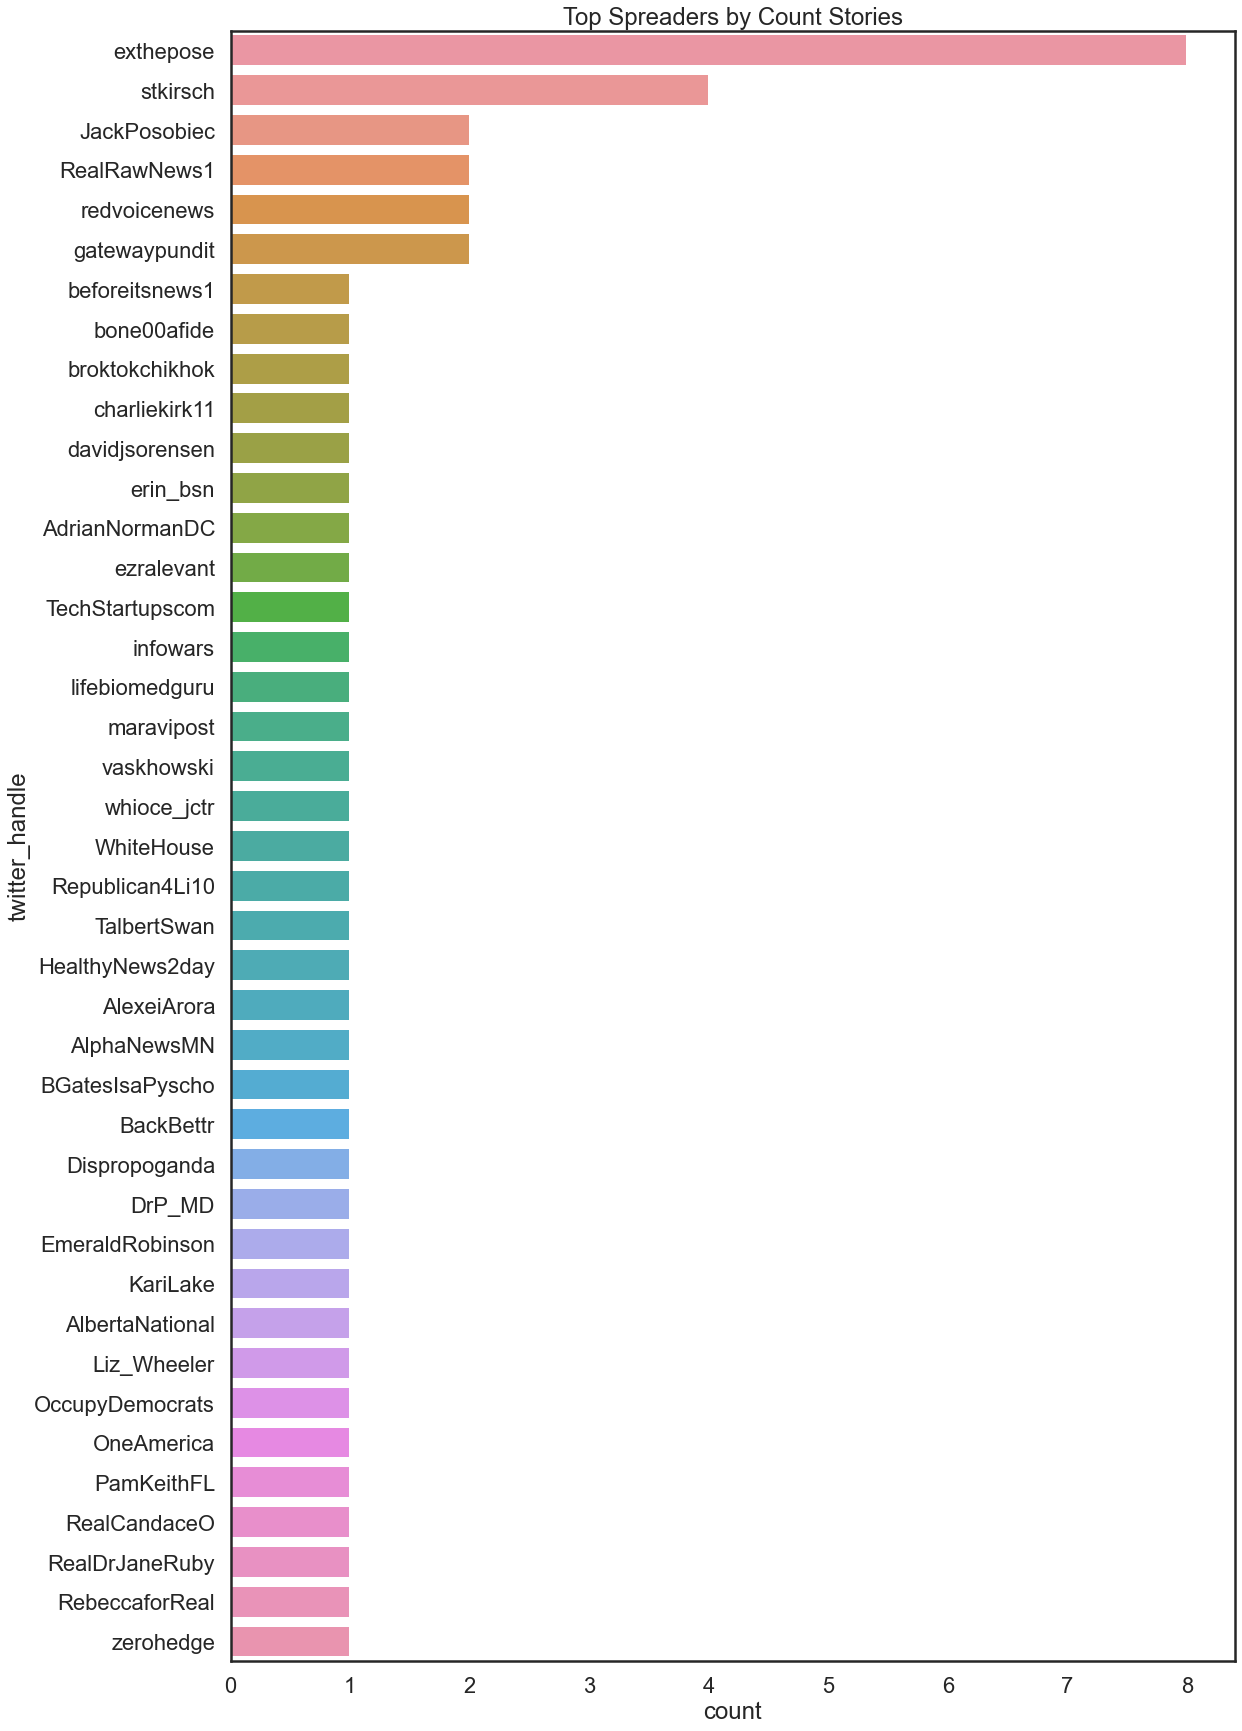

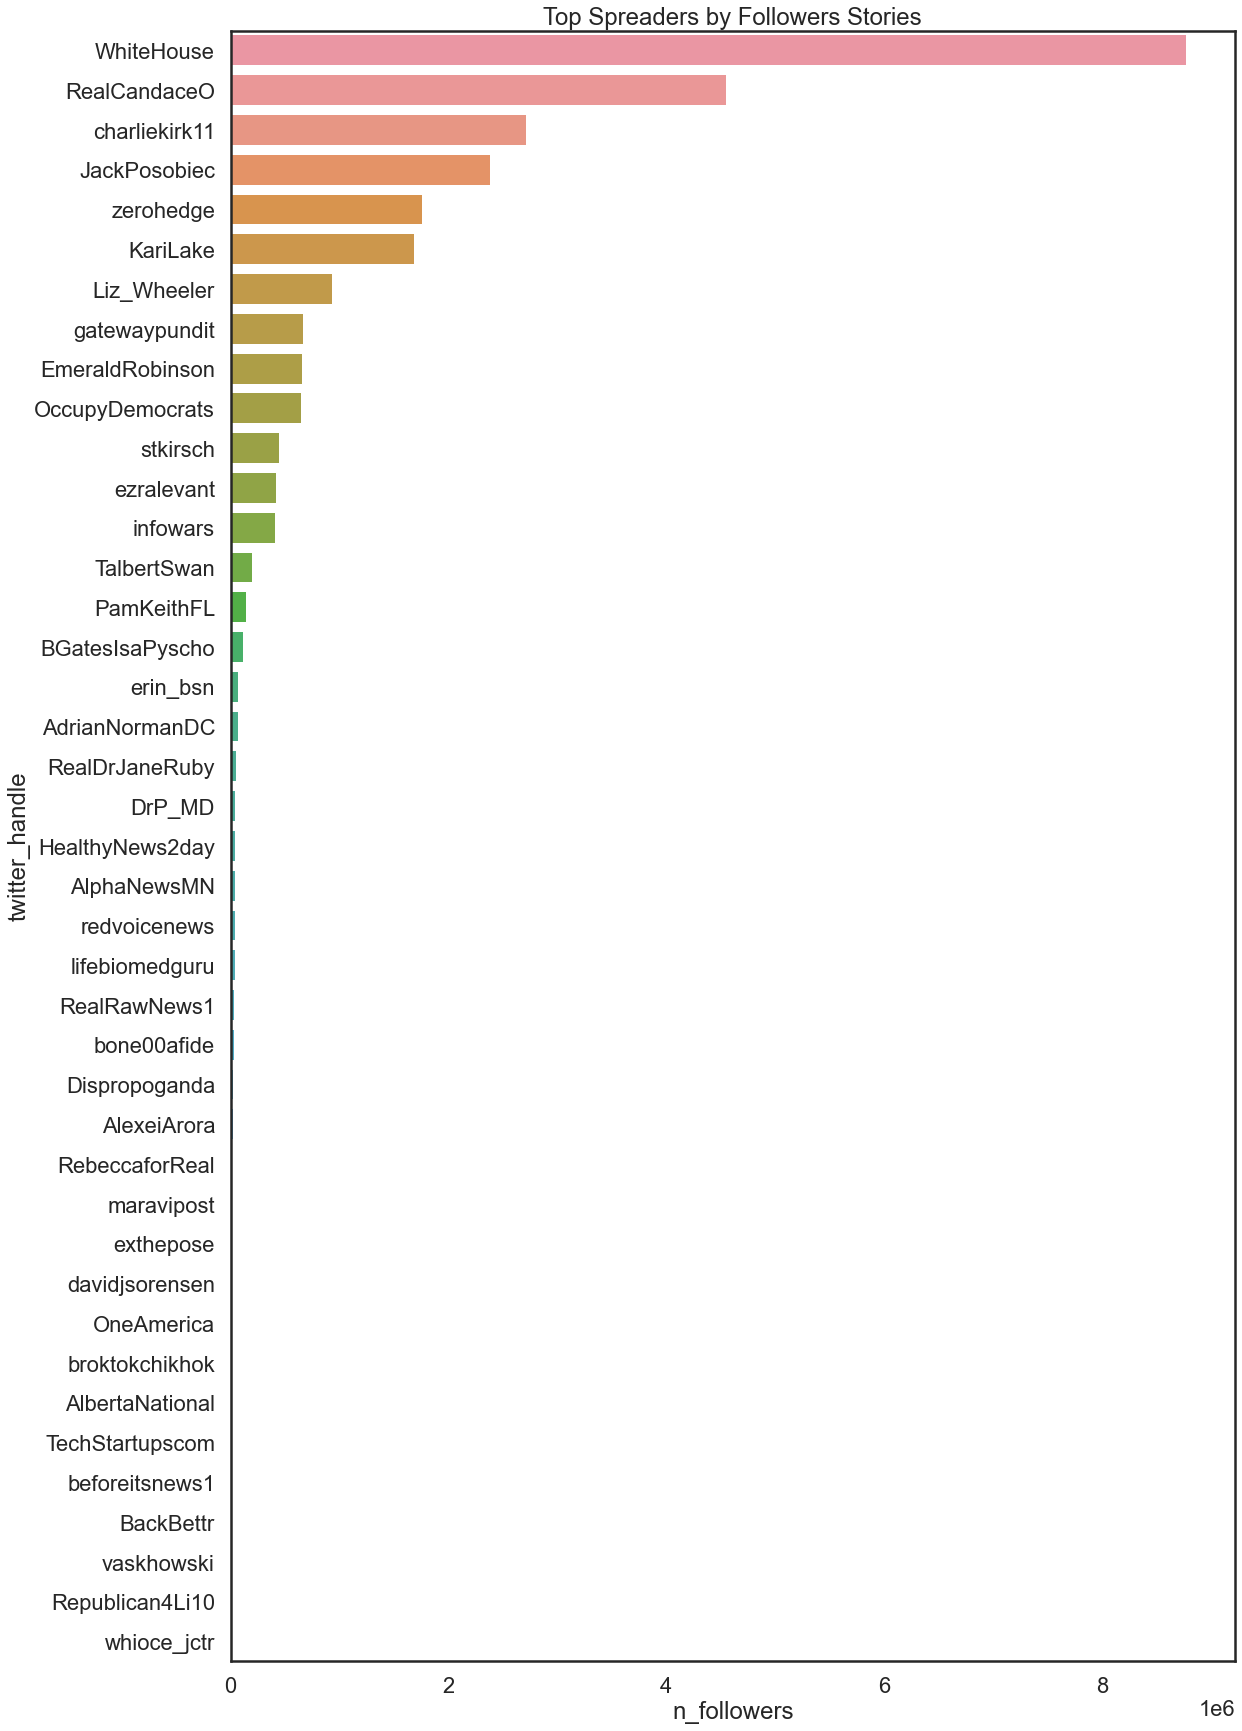

In [63]:
plt.figure(figsize=(18,30))
plt.title("Top Spreaders by Count Stories")
sns.set(context="poster", style='white')
sns.barplot(data=new_df.sort_values(by=['count'], ascending=False), y='twitter_handle', x='count')
plt.show()

plt.figure(figsize=(18,30))
plt.title("Top Spreaders by Followers Stories")
sns.set(context="poster", style='white')
sns.barplot(data=new_df.sort_values(by=['n_followers'], ascending=False), y='twitter_handle', x='n_followers')
plt.show()